In [42]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

# Outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [43]:
# Read in raw data files
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [44]:
# Concatenate raw data files into one dataframe
df = pd.concat([df_train, df_test])

# Preprocessing

## NaN values
Looking at the dataset, there are many rows are completely consisted of NaN values, we need to drop all these rows since they have no effect for the prediction.

In [45]:
# Preview dataframe
df

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Remove rows which are completely null from dataframe
df = df[df.isnull().sum(axis=1) < df.shape[1]]
df

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,c4ab66f9-833c-43b8-879c-4f8bcb64dd14,8ee2002b-8fb6-4af0-ab74-25a1c23e7647,NaN,157806.0,Short Term,731.0,1514376.0,6 years,Rent,Debt Consolidation,4795.41,12.5,NaN,9.0,0.0,87058.0,234410.0,0.0,0.0
9996,bbd3a392-01b4-4e0e-9c28-b2a4a39beac7,6c306306-f5c2-4db5-b74a-af2895123ecb,NaN,132550.0,Short Term,718.0,763192.0,4 years,Home Mortgage,Debt Consolidation,12401.87,9.9,20.0,8.0,0.0,74309.0,329692.0,0.0,0.0
9997,da9870de-4280-46a3-8fc6-91cfe5bfde9d,cc94e25e-1060-4465-b603-194e122f0239,NaN,223212.0,Long Term,NaN,NaN,NaN,Rent,Debt Consolidation,4354.42,27.2,NaN,8.0,1.0,99636.0,568370.0,1.0,0.0
9998,0cc8e0e0-1bc6-49d7-ad0f-0598b647458f,f90cf410-a34b-49e7-8af9-2b405e17b827,NaN,99999999.0,Short Term,721.0,972097.0,10+ years,Home Mortgage,Debt Consolidation,12232.20,16.8,24.0,8.0,1.0,184984.0,240658.0,0.0,0.0


# Incorrect Values

In [47]:
df.describe(include = np.number)

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,1.100000e+05,88865.000000,8.886500e+04,110000.000000,110000.000000,51553.000000,110000.000000,110000.000000,1.100000e+05,1.099980e+05,109774.000000,109989.000000
mean,1.174621e+07,1076.594644,1.377449e+06,18468.526823,18.202485,34.907086,11.124491,0.168055,2.942822e+05,7.541012e+05,0.117614,0.029448
std,3.176716e+07,1475.581902,1.063920e+06,12195.564391,7.015575,21.965315,5.011093,0.484389,3.772773e+05,8.014002e+06,0.351290,0.261054
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.795860e+05,705.000000,8.488440e+05,10211.930000,13.500000,16.000000,8.000000,0.000000,1.121950e+05,2.731575e+05,0.000000,0.000000
50%,3.120260e+05,724.000000,1.173459e+06,16202.440000,16.900000,32.000000,10.000000,0.000000,2.096650e+05,4.673900e+05,0.000000,0.000000
75%,5.239300e+05,741.000000,1.651670e+06,23997.522500,21.700000,51.000000,14.000000,0.000000,3.674838e+05,7.831945e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.000000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


As we can see that the maximum value for the "Credit Score" feature is 7510 which could be a mistake that the number is ten times smaller, so 7510 could be 751. Therefore, we check how many rows have Credit Score value higher than 850.

In [48]:
df_creditScore = df[df['Credit Score'] > 850]
print("Amount of Credit Score higher than 850:",len(df_creditScore))
print("Minimum Credit Score:",min(df_creditScore['Credit Score']))
print("Maximum Credit Score:",max(df_creditScore['Credit Score']))

Amount of Credit Score higher than 850: 5004
Minimum Credit Score: 5850.0
Maximum Credit Score: 7510.0


Since the generic FICO Score has a score range of 300 to 850, we choose to lower the Credit Score's value 5850 ~ 7510 ten times smaller to 585 ~ 751.

In [49]:
# Replace invalid credit scores (above 850 with an extra 0 entered) with credit score 10X smaller
df['Credit Score'] = np.where(df['Credit Score'] > 850, df['Credit Score']/10, df['Credit Score'])

In [50]:
# Drop rows with contaminated credit score (invalid credit score value)
df = df[df['Credit Score'] <= 850]
df = df.reset_index(drop=True)
print("Minimum Credit Score:",min(df['Credit Score']))
print("Maximum Credit Score:",max(df['Credit Score']))

Minimum Credit Score: 585.0
Maximum Credit Score: 751.0


Now the range for Credit Score is 585 ~ 751.

In [51]:
# Preview dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88865 entries, 0 to 88864
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88865 non-null  object 
 1   Customer ID                   88865 non-null  object 
 2   Loan Status                   80846 non-null  object 
 3   Current Loan Amount           88865 non-null  float64
 4   Term                          88865 non-null  object 
 5   Credit Score                  88865 non-null  float64
 6   Annual Income                 88865 non-null  float64
 7   Years in current job          85111 non-null  object 
 8   Home Ownership                88865 non-null  object 
 9   Purpose                       88865 non-null  object 
 10  Monthly Debt                  88865 non-null  float64
 11  Years of Credit History       88865 non-null  float64
 12  Months since last delinquent  41930 non-null  float64
 13  N

# Missing Values
We check the percentage of missing value in each column.

In [52]:
# See how many missing values per column
df.isna().sum()/len(df)

Loan ID                         0.000000
Customer ID                     0.000000
Loan Status                     0.090238
Current Loan Amount             0.000000
Term                            0.000000
Credit Score                    0.000000
Annual Income                   0.000000
Years in current job            0.042244
Home Ownership                  0.000000
Purpose                         0.000000
Monthly Debt                    0.000000
Years of Credit History         0.000000
Months since last delinquent    0.528161
Number of Open Accounts         0.000000
Number of Credit Problems       0.000000
Current Credit Balance          0.000000
Maximum Open Credit             0.000011
Bankruptcies                    0.002037
Tax Liens                       0.000079
dtype: float64

Most of the features have less than 5% missing values, but the feature "Months since last delinquent" has more than 50% missing value. Our strategy to deal with the missing values is fill in the mean value and zero.

In [53]:
#fill in missing values with zero and observe distribution 
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)

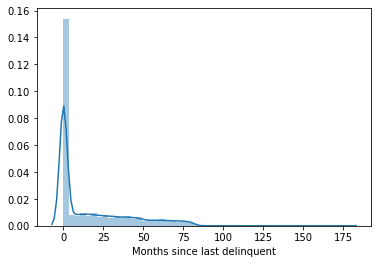

In [54]:
import seaborn as sns
sns.distplot(df['Months since last delinquent'])

Accoding to the plot, we can divdie Months since last delinquent into following categories: 0: no delinquent, 0~25: 2 years, 25~50: 4 years, 50 ~75: 6 years, >75: over 6 years. We also change the feature name from "Months since last delinquent" to "Delinquent Time".

In [55]:
df['Delinquent Time'] = 0
df.loc[(df['Months since last delinquent'] == 0), 'Delinquent Time'] = 0
df.loc[(df['Months since last delinquent']>0)&(df['Months since last delinquent']<= 25),'Delinquent Time'] = 2
df.loc[(df['Months since last delinquent']>25)&(df['Months since last delinquent']<= 50),'Delinquent Time'] = 4
df.loc[(df['Months since last delinquent']>50)&(df['Months since last delinquent']<= 75),'Delinquent Time'] = 6
df.loc[(df['Months since last delinquent']>75),'Delinquent Time'] = 6

In [56]:
to_drop = 'Months since last delinquent'
df = df.drop(to_drop, axis = 1)

There is no more missing value in the "Delinquent Time" feature.

In [57]:
df['Delinquent Time'].unique()

array([0, 4, 2, 6], dtype=int64)

For other features, we impute missing values with the mean value except "bankruptcies" and "years in current job". 

In [58]:
numeric = df.select_dtypes('number')
numeric.drop(columns = 'Bankruptcies')
numeric_cols = numeric.columns
df[numeric.columns] = numeric.fillna(numeric.mean())

For the "bankruptcies" feature, we fill the NaN value with 0 

In [59]:
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)

We impute missing values for categorical data with the mode.

In [60]:
categoric = df.select_dtypes('object')
categoric = categoric.drop(columns = 'Years in current job')
df[categoric.columns] = categoric.fillna(categoric.agg(lambda x: x.mode().values[0]))

Fill NaN for Years in current job with'< 1 year'

In [61]:
df['Years in current job'] = df['Years in current job'].fillna('< 1 year')

Confirm all missing values have been filled in so that there should be no more missing values in the dataset.

In [62]:
df.isna().sum()

Loan ID                      0
Customer ID                  0
Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Annual Income                0
Years in current job         0
Home Ownership               0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
Delinquent Time              0
dtype: int64

Check unique values for each column.

In [63]:
df.nunique()

Loan ID                      72344
Customer ID                  72344
Loan Status                      2
Current Loan Amount          21046
Term                             2
Credit Score                   167
Annual Income                37853
Years in current job            11
Home Ownership                   4
Purpose                         16
Monthly Debt                 59476
Years of Credit History        501
Number of Open Accounts         51
Number of Credit Problems       14
Current Credit Balance       30994
Maximum Open Credit          41585
Bankruptcies                     9
Tax Liens                       14
Delinquent Time                  4
dtype: int64

Check unique values for each categorical column

In [64]:
df[categoric.columns].nunique()

Loan ID           72344
Customer ID       72344
Loan Status           2
Term                  2
Home Ownership        4
Purpose              16
dtype: int64

We apply label encoding for all the categorical columns

In [65]:
le = LabelEncoder()
df[categoric.columns] = df[categoric.columns].apply(le.fit_transform)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Delinquent Time
0,5898,43043,1,445412.0,1,709.0,1167493.0,8 years,1,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8 years,2,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4
2,33793,65397,1,347666.0,0,721.0,806949.0,3 years,2,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0
3,39047,22612,0,206602.0,1,729.0,896857.0,10+ years,1,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0
4,11116,40916,1,217646.0,1,730.0,1184194.0,< 1 year,1,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2


Convert 'Years in current job' to numerical column - Note: Numerical tranformation converts '< 1 year' to 0 and '10+ years' to 10 for simplicity

In [66]:
df['Years in current job'] = df['Years in current job'].replace({'< 1 year':0, '1 year': 1, '2 years': 2,
                                                                 '3 years':3, '4 years':4, '5 years':5, 
                                                                 '6 years':6, '7 years':7, '8 years':8,
                                                                 '9 years': 9, '10+ years': 10})
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Delinquent Time
0,5898,43043,1,445412.0,1,709.0,1167493.0,8,1,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8,2,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4
2,33793,65397,1,347666.0,0,721.0,806949.0,3,2,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0
3,39047,22612,0,206602.0,1,729.0,896857.0,10,1,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0
4,11116,40916,1,217646.0,1,730.0,1184194.0,0,1,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2


In [67]:
# Get more insight into 'Credit Score' column
df['Credit Score'].describe()

count    88865.000000
mean       716.323930
std         28.291419
min        585.000000
25%        703.000000
50%        722.000000
75%        739.000000
max        751.000000
Name: Credit Score, dtype: float64

We added a new column "Credit Score Range" for classification model. We decide to separate "Credit Score" into six bins.

In [68]:
df['Credit Score Range'] = pd.cut(df['Credit Score'], 6)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Delinquent Time,Credit Score Range
0,5898,43043,1,445412.0,1,709.0,1167493.0,8,1,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0,"(695.667, 723.333]"
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8,2,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4,"(723.333, 751.0]"
2,33793,65397,1,347666.0,0,721.0,806949.0,3,2,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0,"(695.667, 723.333]"
3,39047,22612,0,206602.0,1,729.0,896857.0,10,1,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0,"(723.333, 751.0]"
4,11116,40916,1,217646.0,1,730.0,1184194.0,0,1,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2,"(723.333, 751.0]"


Class=(584.834, 612.667], n=554 (0.623%)
Class=(612.667, 640.333], n=1496 (1.683%)
Class=(640.333, 668.0], n=4307 (4.847%)
Class=(668.0, 695.667], n=10436 (11.744%)
Class=(695.667, 723.333], n=29691 (33.411%)
Class=(723.333, 751.0], n=42381 (47.691%)


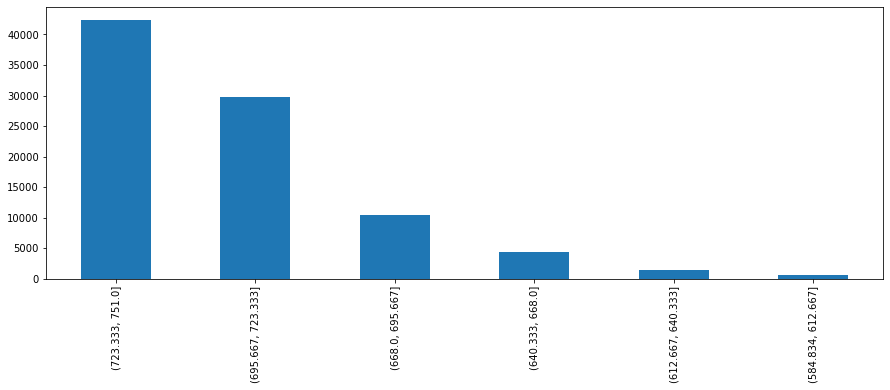

In [69]:
from collections import Counter
counted_target = Counter(df['Credit Score Range'])
for Range, rangeAmount in sorted(counted_target.items()):
    percentage = rangeAmount / len(df['Credit Score Range']) * 100
    print('Class=%s, n=%d (%.3f%%)' % (Range, rangeAmount, percentage))
df['Credit Score Range'].value_counts().plot(kind='bar',figsize=(15,5))

We apply min-max normalization for all the numeric columns that makes sure all the numric values are in the same range. 

In [70]:
from sklearn.preprocessing import LabelEncoder
# Normalize continuous columns
numeric = df.select_dtypes('number')
transformer = preprocessing.MinMaxScaler()
numeric_normalized = transformer.fit_transform(numeric.values)
df[numeric.columns] = numeric_normalized

# Label Credit Score Range with integers 
le = LabelEncoder()
df[["Credit Score Range"]] = df[["Credit Score Range"]].apply(le.fit_transform)

View final dataframe after processing

In [71]:
df

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Delinquent Time,Credit Score Range
0,0.081528,0.594985,1.0,0.004342,1.0,0.746988,0.006592,0.8,0.333333,0.333333,0.011965,0.202096,0.066667,0.066667,0.006940,0.000271,0.142857,0.0,0.000000,4
1,0.309318,0.371466,1.0,1.000000,1.0,0.939759,0.013024,0.8,0.666667,0.200000,0.066998,0.167665,0.226667,0.066667,0.009063,0.000487,0.000000,0.0,0.666667,5
2,0.467122,0.903985,1.0,0.003365,0.0,0.819277,0.004413,0.3,0.666667,0.200000,0.020057,0.124251,0.106667,0.000000,0.007796,0.000251,0.000000,0.0,0.000000,4
3,0.539748,0.312567,0.0,0.001954,1.0,0.867470,0.004957,1.0,0.333333,0.200000,0.037554,0.203593,0.066667,0.000000,0.006549,0.000177,0.000000,0.0,0.000000,5
4,0.153657,0.565583,1.0,0.002064,1.0,0.873494,0.006693,0.0,0.333333,0.200000,0.024906,0.238024,0.160000,0.066667,0.003716,0.000177,0.142857,0.0,0.333333,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88860,0.635777,0.429482,1.0,0.004314,1.0,0.927711,0.008776,0.7,0.333333,0.200000,0.044728,0.194611,0.133333,0.000000,0.012751,0.000427,0.000000,0.0,1.000000,5
88861,0.769598,0.558257,1.0,0.001466,1.0,0.879518,0.008688,0.6,1.000000,0.200000,0.011003,0.131737,0.106667,0.000000,0.002648,0.000152,0.000000,0.0,0.000000,5
88862,0.734902,0.423828,1.0,0.001213,1.0,0.801205,0.004149,0.4,0.333333,0.200000,0.028455,0.092814,0.093333,0.000000,0.002260,0.000214,0.000000,0.0,0.333333,4
88863,0.050081,0.972796,1.0,1.000000,1.0,0.819277,0.005411,1.0,0.333333,0.200000,0.028066,0.196108,0.093333,0.066667,0.005626,0.000156,0.000000,0.0,0.333333,4


# Outlier Detection
We use Isolation Forest and Local Outlier Factor algorithms to detect if there is any outlier in the dataset

In [72]:
def outlier_dection(df): 
    detectors = [IsolationForest(n_jobs=-1), LocalOutlierFactor(n_jobs=-1)]
    detected_outliers = []

    for detectorNum in detectors:
        detected_outliers.append(detectorNum.fit_predict(df))
        
    return detected_outliers

In [73]:
outliers_results = outlier_dection(df)
outliers = []
percentage = []
for i in range(2):
    outliers.append(np.array(np.where(outliers_results[i] == -1)).shape[1])
    percentage.append(round(outliers[i]/len(df)*100,2))

In [74]:
outliers_report = pd.DataFrame({
   'Detected outliers':outliers,
    'Percentage(%)': percentage,
   }, index=['Isolation Forest', 'Local Outlier Factor'])
outliers_report

,Detected outliers,Percentage(%)
Isolation Forest,11274,12.69
Local Outlier Factor,762,0.86


In [83]:
iso_outliers = np.where(outliers_results[0] == -1)
lof_outliers = np.where(outliers_results[1] == -1)

lof_iso_matched_detection = np.intersect1d(lof_outliers, iso_outliers)
print("Number of agreement detection (LOF VS ISO) :", len(lof_iso_matched_detection))
print("Agreement detection percentage: %.2f%%" % (len(lof_iso_matched_detection)/(outliers[0]+outliers[1])*100))

Number of agreement detection (LOF VS ISO) : 437
Agreement detection percentage: 3.63%


Since there was poor agreement between LOF and ISO, and these two algorithm have a huge difference number of detected outliers, we decided not to drop any of outliers in the dataset.

In [56]:
# Write processed dataframe to csv file called 'credit.csv'
df.to_csv('./datasets/credit.csv', index=False)